<a href="https://colab.research.google.com/github/studerAD15/Liver-diesease/blob/main/liver_disease(cnn).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("orvile/annotated-ultrasound-liver-images-dataset")

print("Path to dataset files:", path)

100%|██████████| 67.1M/67.1M [00:04<00:00, 16.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/orvile/annotated-ultrasound-liver-images-dataset/versions/2


In [2]:
import os
os.listdir(path)


['dataset.csv', '7272660']

In [3]:
import os

image_folder = os.path.join(path, "7272660")
os.listdir(image_folder)


['Malignant', 'Normal', 'Benign']

In [ ]:
#cnn model with dataset Annotated Ultrasound Liver images Dataset

In [4]:
# Enable reproducibility
import numpy as np
import tensorflow as tf

np.random.seed(42)
tf.random.set_seed(42)

# Install required libraries
!pip install -q tensorflow keras matplotlib seaborn scikit-learn kagglehub opencv-python

# Imports
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os
import cv2
import kagglehub

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
# Download dataset
path = kagglehub.dataset_download(
    "orvile/annotated-ultrasound-liver-images-dataset"
)

print("Dataset root path:", path)
print("Root contents:", os.listdir(path))

# Actual image folder
DATASET_PATH = os.path.join(path, "7272660")
print("Image folders:", os.listdir(DATASET_PATH))


Using Colab cache for faster access to the 'annotated-ultrasound-liver-images-dataset' dataset.
Dataset root path: /kaggle/input/annotated-ultrasound-liver-images-dataset
Root contents: ['7272660', 'dataset.csv']
Image folders: ['Benign', 'Normal', 'Malignant']


In [6]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 50

CLASS_NAMES = ['Normal', 'Benign', 'Malignant']

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest',
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print("Training samples:", train_generator.samples)
print("Validation samples:", validation_generator.samples)
print("Class indices:", train_generator.class_indices)


Found 588 images belonging to 3 classes.
Found 147 images belonging to 3 classes.
Training samples: 588
Validation samples: 147
Class indices: {'Benign': 0, 'Malignant': 1, 'Normal': 2}


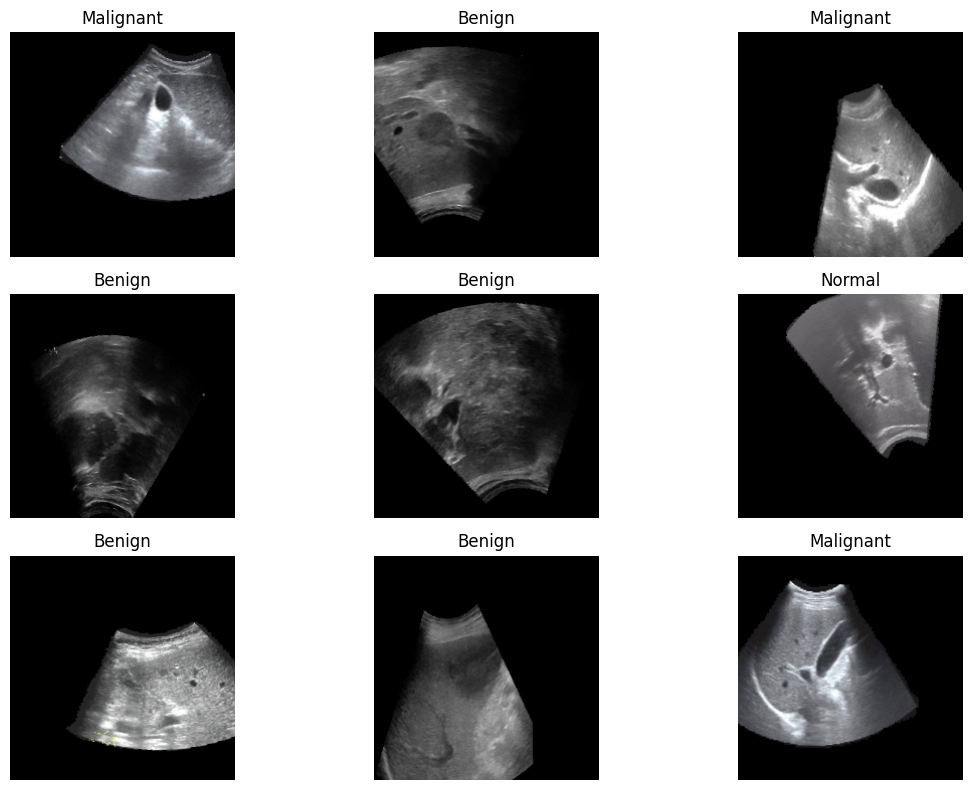

In [7]:
def visualize_samples(generator, class_names, samples_per_class=3):
    images, labels = next(generator)
    plt.figure(figsize=(12, 8))

    for i in range(samples_per_class * len(class_names)):
        plt.subplot(len(class_names), samples_per_class, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_samples(train_generator, CLASS_NAMES)


In [8]:
def build_cnn_model(input_shape=(224, 224, 3), num_classes=3):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = build_cnn_model()

model.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy',
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall')]
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    51,380,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 51,804,707 (197.62 MB)

 Trainable params: 51,802,275 (197.61 MB)

 Non-trainable params: 2,432 (9.50 KB)

In [9]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7),
    ModelCheckpoint('best_liver_cnn.h5', monitor='val_accuracy', save_best_only=True)
]

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

model.save("liver_disease_cnn_final.h5")
print("Model saved.")


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3691 - loss: 2.0169 - precision: 0.3633 - recall: 0.3221

19/19 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.3703 - loss: 2.0080 - precision: 0.3650 - recall: 0.3237 - val_accuracy: 0.5918 - val_loss: 1.0077 - val_precision: 0.5918 - val_recall: 0.5918 - learning_rate: 0.0010
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 558ms/step - accuracy: 0.4789 - loss: 1.4956 - precision: 0.4838 - recall: 0.4332 - val_accuracy: 0.5918 - val_loss: 1.2026 - val_precision: 0.5918 - val_recall: 0.5918 - learning_rate: 0.0010
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 525ms/step - accuracy: 0.4740 - loss: 1.5346 - precision: 0.4966 - recall: 0.4264 - val_accuracy: 0.5918 - val_loss: 1.0348 - val_precision: 0.5918 - val_recall: 0.5918 - learning_rate: 0.0010
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 524ms/step - accuracy: 0.4776 - loss: 1.4298 - precision: 0.4874 - recall: 0.4431 - val_accuracy: 0.5918 - val_loss: 1.7349 - val_precision: 0.5918 - val_recall: 0.5918 - learning_rate: 0.0010
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 567ms/step - accuracy: 0.5158 - 

Model saved.


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 730ms/step


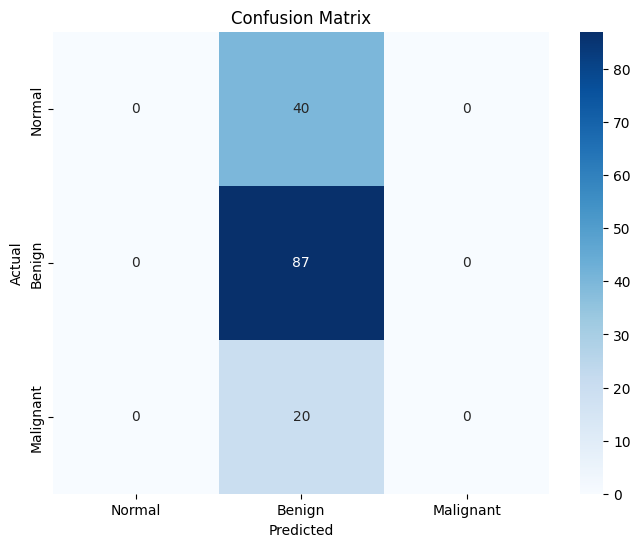

Classification Report:

              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00        40
      Benign       0.59      1.00      0.74        87
   Malignant       0.00      0.00      0.00        20

    accuracy                           0.59       147
   macro avg       0.20      0.33      0.25       147
weighted avg       0.35      0.59      0.44       147



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [10]:
# Predictions
validation_generator.reset()
y_pred = np.argmax(model.predict(validation_generator), axis=1)
y_true = validation_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES,
            cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))


In [11]:
def predict_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    preds = model.predict(img)[0]
    class_id = np.argmax(preds)

    plt.imshow(cv2.imread(image_path)[:,:,::-1])
    plt.title(f"Prediction: {CLASS_NAMES[class_id]} ({preds[class_id]*100:.2f}%)")
    plt.axis('off')
    plt.show()

# Example:
# predict_image("/content/sample_image.jpg")


Saving test_liver.jpg to test_liver.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


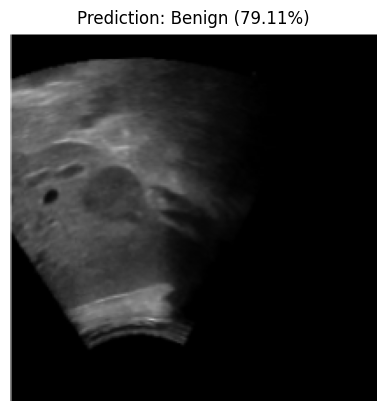

In [12]:
from google.colab import files

uploaded = files.upload()

for file_name in uploaded.keys():
    predict_image("/content/" + file_name)
